In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="multiprocessing.resource_tracker")

import numpy as np
import matplotlib.pyplot as plt

import nbi

In [2]:
print(nbi.__version__)

0.4.1


Let us consider a very simple sine curve model, where $t$ is time, $\omega$ is angular frequency, $A$ is amplitude, and $\phi_0$ is initial phase:<br>
$f(t) = A\cdot\sin(\omega\cdot t+\phi_0$)

Assume parameters from the following uniform distribution:<br>
$\phi_0\in[0,2\pi]$, $A\in[1,5]$, $\omega\in[2\pi,12\pi]$

Also assume Gaussian measurement noise fixed to be $\sigma_0$:<br>
$x_{\rm obs}\sim N(f(t), \sigma=\sigma_0)$

In [3]:
t = np.linspace(0,1,50)
def sine(param):
    phi0, A, omega = param
    return np.sin(omega * t + phi0) * A

In [4]:
# nbi requires prior to be defined with scipy functions
# alternatively, you may supply pre-generated parameters with numpy arrays

from scipy.stats import uniform, truncnorm
prior = {
    'phi0': uniform(loc=0, scale=np.pi*2),
    'A': uniform(loc=1, scale=4),
    'omega': uniform(loc=2*np.pi, scale=10*np.pi)
}
labels = list(prior.keys())
priors = [prior[k] for k in labels]

# One target: SNPE
Let us first consider inference for one target. Randomly sample an observation from prior space and add noise.

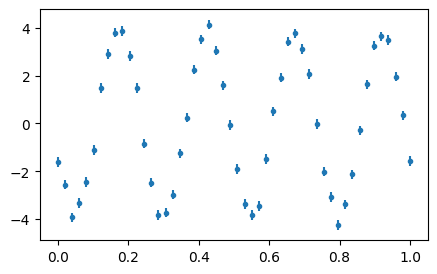

In [5]:
plt.figure(figsize=(5,3))

np.random.seed(0)

# draw random parameter from prior
y_true = [var.rvs(1)[0] for var in priors]

# add fixed gaussian noise of 1
x_err = 0.2
x_obs = sine(y_true) + np.random.normal(size=50) * x_err
plt.errorbar(t, x_obs, yerr=x_err, fmt='.')

plt.show()

In [6]:
# hyperparameters for the normalizing flow
flow = {
    'n_dims': 3,              # dimension of parameter space
    'flow_hidden': 64,
    'num_blocks': 5
}

# the NBI package provides the "ResNet-GRU" network as the default
# featurizer network for sequential data
featurizer = {
    'type': 'resnet-gru',
    'norm': 'weight_norm',
    'dim_in': 1,
    'dim_out': 64,
    'dim_conv_max': 256,
    'depth': 3
}

# initialize NBI engine
engine = nbi.NBI(
    flow=flow,
    featurizer=featurizer,
    simulator=sine,
    priors=priors,
    labels=labels,
    device='cpu',
    n_jobs=10
)

Generating simulations


512it [00:00, 2462.02it/s]
/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.w

Effective sample size for current/all rounds 0.0/0.0

---------------------- Round: 0 ----------------------


- Val, Loglike in nats: 4.136803: 100%|█████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 7085.35it/s]


- Val, Loglike in nats: 6.002061: 100%|█████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 6002.20it/s]


- Val, Loglike in nats: 6.225882: 100%|█████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 6518.88it/s]


Generating simulations


512it [00:00, 2000.44it/s]


Effective sample size for current/all rounds 125.1/125.1


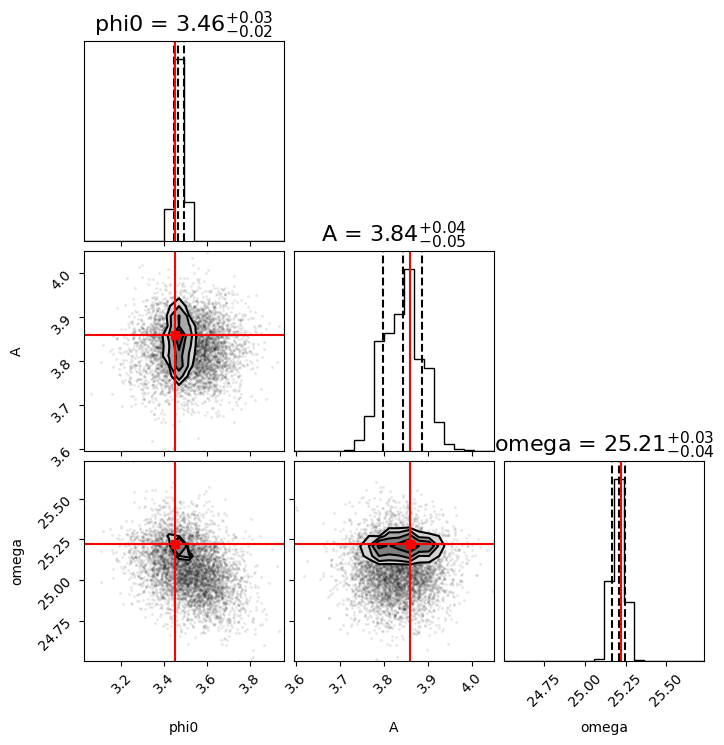


---------------------- Round: 1 ----------------------


- Val, Loglike in nats: -1.815995: 100%|████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 7274.80it/s]


- Val, Loglike in nats: -0.628358: 100%|████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 7303.37it/s]


- Val, Loglike in nats: -0.515855: 100%|████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 7132.03it/s]


Generating simulations


512it [00:00, 1962.18it/s]


Effective sample size for current/all rounds 3427.3/3552.4


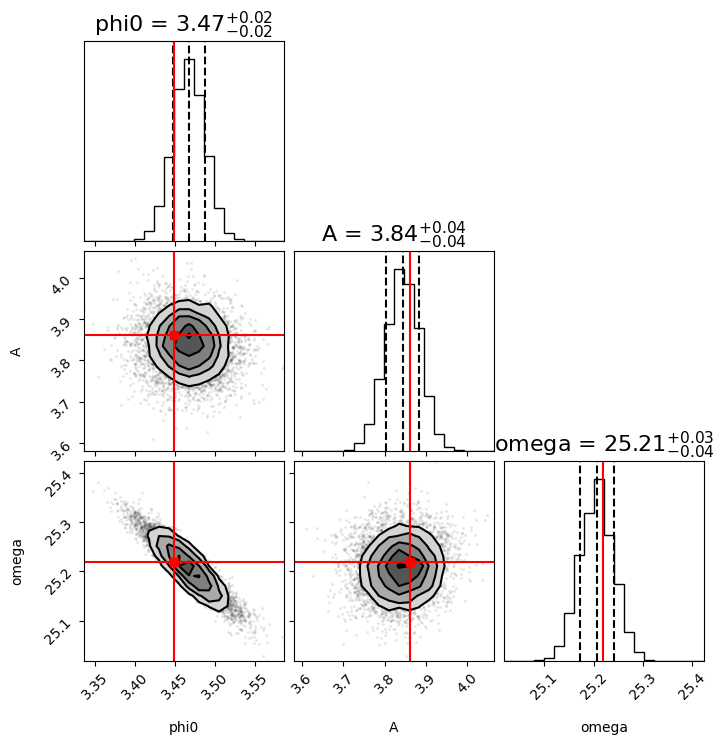


---------------------- Round: 2 ----------------------


- Val, Loglike in nats: -2.345716: 100%|████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 6982.05it/s]


- Val, Loglike in nats: -2.298937: 100%|████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 7142.57it/s]

early stopping, loading state dict from epoch 30


Generating simulations


512it [00:00, 2016.02it/s]


Effective sample size for current/all rounds 2095.9/5648.3


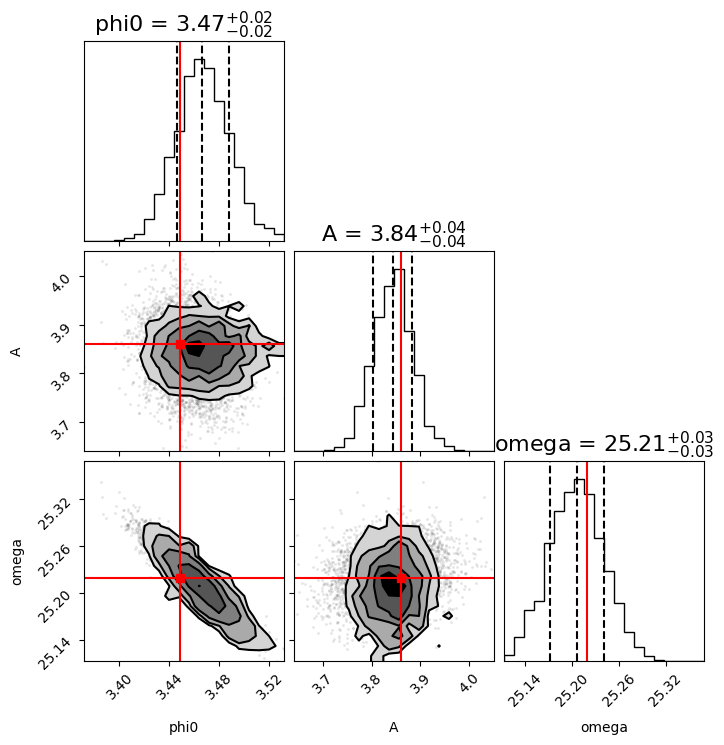

Early stop: Surrogate posterior did not improve for this round
Loaded state from round  1


In [7]:
engine.fit(
    x_obs=x_obs,
    y_true=y_true,
    n_sims=5120,
    n_rounds=5,
    n_epochs=75,
    batch_size=256,
    lr=0.001,
    early_stop_train=True,        # If sampling efficiency is reduced, stop and revert to previous round
    early_stop_patience=10,        # Within a round, wait this many epochs before early stopping
    noise=np.array([0.2]*50)        # homogeneous noise; used for importance sampling
)

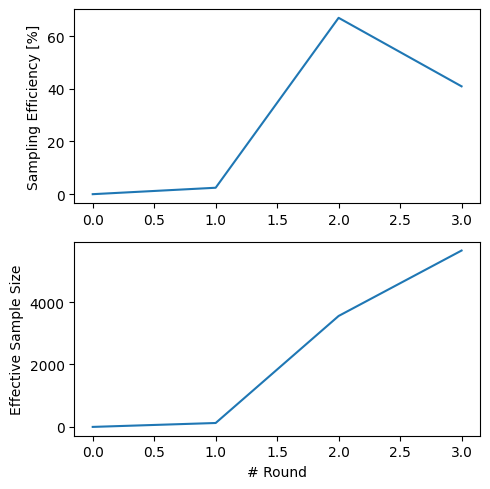

In [10]:
plt.rcParams['figure.dpi']=100
plt.figure(figsize=(5,5))
plt.subplot(211)
plt.plot(np.array(engine.neff)/5120*100)
plt.ylabel('Sampling Efficiency [%]')
plt.subplot(212)
plt.plot([np.sum(engine.neff[:i+1]) for i in range(4)])
plt.ylabel('Effective Sample Size')
plt.xlabel('# Round')
plt.tight_layout()

As we see, after the 2nd round of training the sampling efficiency is as high as ~50%, meaning the NDE posterior is nearly the true posterior. As expected, the third round of training degraded the result due to the use of NLL loss. Therefore, we revert to the second round. Nevertheless, the third round still contributed 147 effective posterior samples. In practice, we can specify the f_accept_min parameter for a sampling efficiency threshold to terminate training early.

To generate more effective posterior samples, let us draw 10000 more samples from the 2nd round NDE. The corner plot shows the importance reweighted posterior (contour) as well as the unweighted full sample (scatter).

Generating simulations


1000it [00:00, 3168.67it/s]


Effective Sample Size = 6788.0
Sampling efficiency = 67.9%


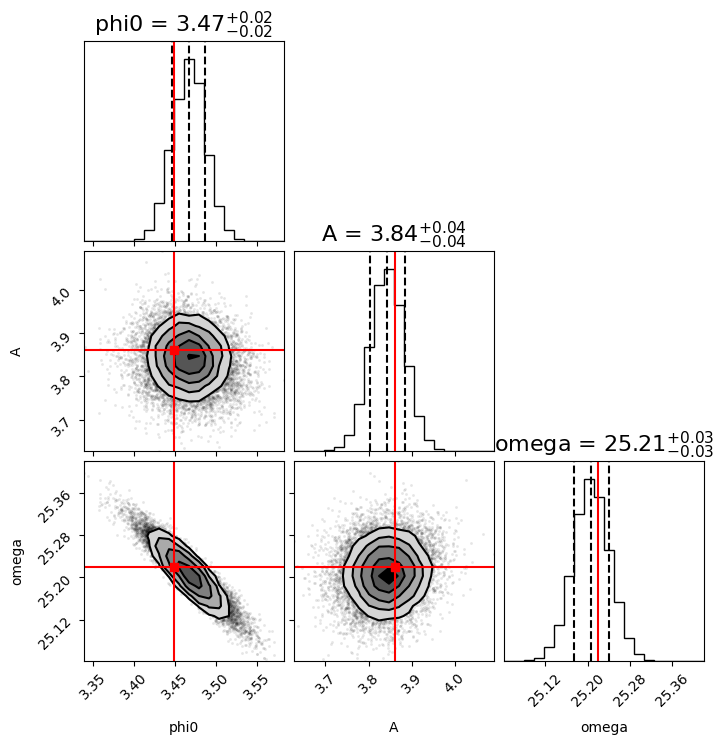

In [11]:
y_pred, weights = engine.predict(x_obs, x_err=np.array([0.2]*50),y_true=y_true, n_samples=10000, corner_reweight=True)

# Many targets: ANPE
if we care about a large number of different x_obs, then train nbi for only 1 round on more samples generated from the prior space of interest.

In [5]:
# let's say we have a large set of observed sine curves with different noise levels
# instead of initializing the NBI engine with fixed noise, we have provide it with a
# noise function that takes in noise free "x" and returns a noisified x

# the noise function can include any component of the forward model that is cheap
def noise(x, y):
    rand = np.random.normal(0, 1, size=x.shape[0])
    
    # let's say x_err is drawn from [0.05, 1]
    x_err = np.random.uniform() * 0.95 + 0.05
    x_noise = x + rand * x_err
    return x_noise, y

In [6]:
# hyperparameters for the normalizing flow
flow = {
    'n_dims': 3,              # dimension of parameter space
    'flow_hidden': 64,
    'num_blocks': 5
}

# the NBI package provides the "ResNet-GRU" network as the default
# featurizer network for sequential data
featurizer = {
    'type': 'resnet-gru',
    'norm': 'weight_norm',
    'dim_in': 1,
    'dim_out': 64,
    'dim_conv_max': 256,
    'depth': 3
}

# initialize NBI engine
engine = nbi.NBI(
    flow=flow,
    featurizer=featurizer,
    simulator=sine,
    priors=priors,
    labels=labels,
    device='cpu',
    n_jobs=10
)

To compare with SNPE, let us adapt the same number of training samples (2560) that allowed for the ~50% sampling efficiency for previous SNPE example. Presumably, ANPE would not achieve that 50% sampling efficiency seen with SNPE for that particular sine curve, which uses active learning. Of course, the benifit is that we may do inference on any observations within the prior

In [7]:
engine.fit(
    n_sims=5120*4,
    n_rounds=1,
    n_epochs=75,
    batch_size=256,
    lr=0.001,
    early_stop_patience=10,        # Within a round, wait this many epochs before early stopping
    noise=noise
)

Generating simulations


2048it [00:00, 2178.53it/s]



---------------------- Round: 0 ----------------------


/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: Ther

Epoch 34: Train, Loglike in nats: 4.565025: 100%|███████████████████████████████████████████████████████████| 18432/18432 [00:05<00:00, 3634.79it/s]


Epoch 61: Train, Loglike in nats: 5.477486: 100%|███████████████████████████████████████████████████████████| 18432/18432 [00:04<00:00, 3702.40it/s]


- Val, Loglike in nats: 5.536048: 100%|███████████████████████████████████████████████████████████████████████| 2048/2048 [00:00<00:00, 8386.22it/s]
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


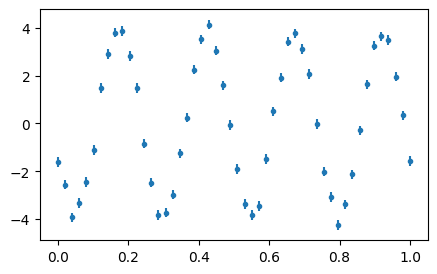

In [8]:
# same example observation as SNPE

plt.figure(figsize=(5,3))

np.random.seed(0)

# draw random parameter from prior
y_true = [var.rvs(1)[0] for var in priors]

# add fixed gaussian noise of 1
x_err = 0.2
x_obs = sine(y_true) + np.random.normal(size=50) * x_err
plt.errorbar(t, x_obs, yerr=x_err, fmt='.')

plt.show()

Generating simulations


1000it [00:00, 3271.38it/s]


Effective Sample Size = 738.7
Sampling efficiency = 7.4%


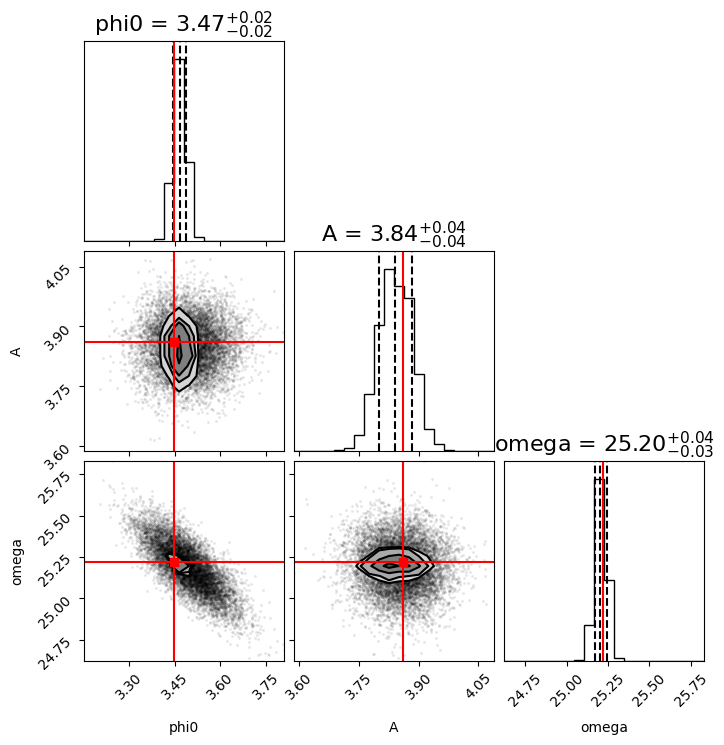

In [9]:
y_pred, weights = engine.predict(x_obs, x_err=np.array([0.2]*50), y_true=y_true, n_samples=10000, corner_reweight=True)

7% is much lower than SNPE. But the advantage of ANPE is that we can do inference on any observation/noise within the prior:

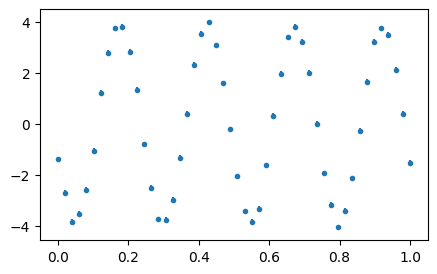

Generating simulations


1000it [00:00, 2375.80it/s]


Effective Sample Size = 110.3
Sampling efficiency = 1.1%


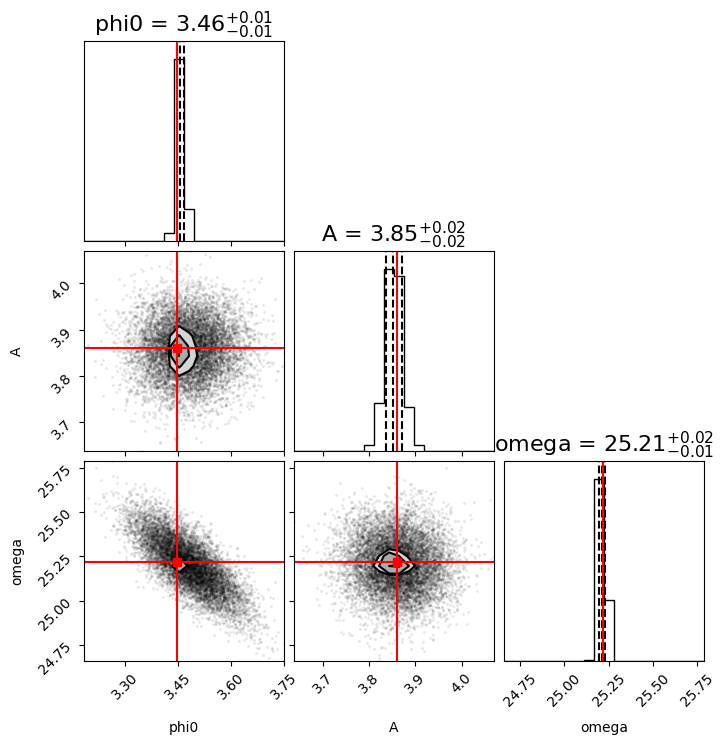

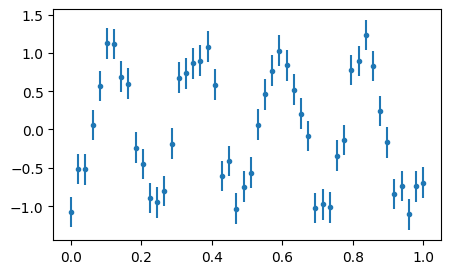

Samples outside prior N = 3222
Generating simulations


678it [00:00, 2268.80it/s]


Effective Sample Size = 687.3
Sampling efficiency = 6.9%


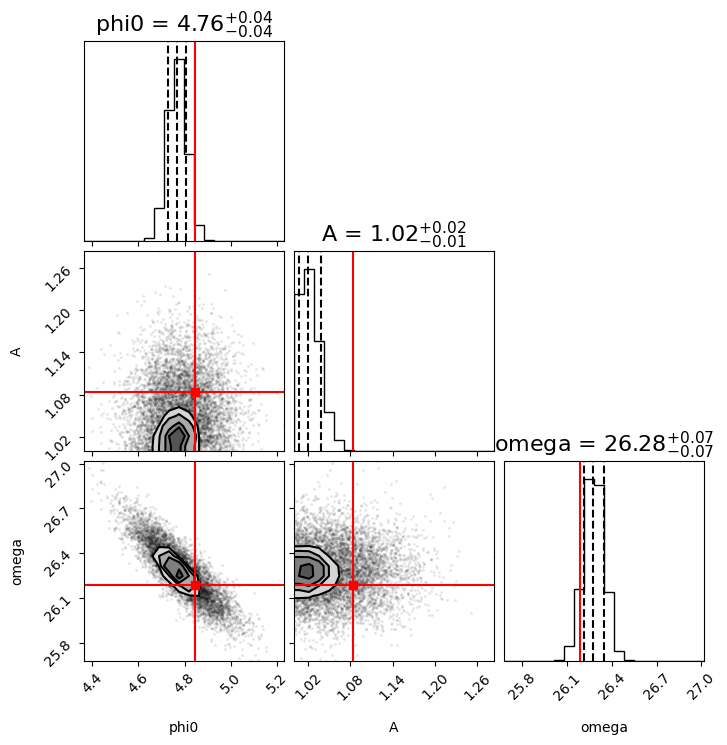

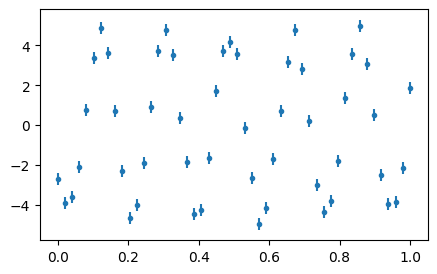

Generating simulations


1000it [00:00, 2403.19it/s]


Effective Sample Size = 62.8
Sampling efficiency = 0.6%


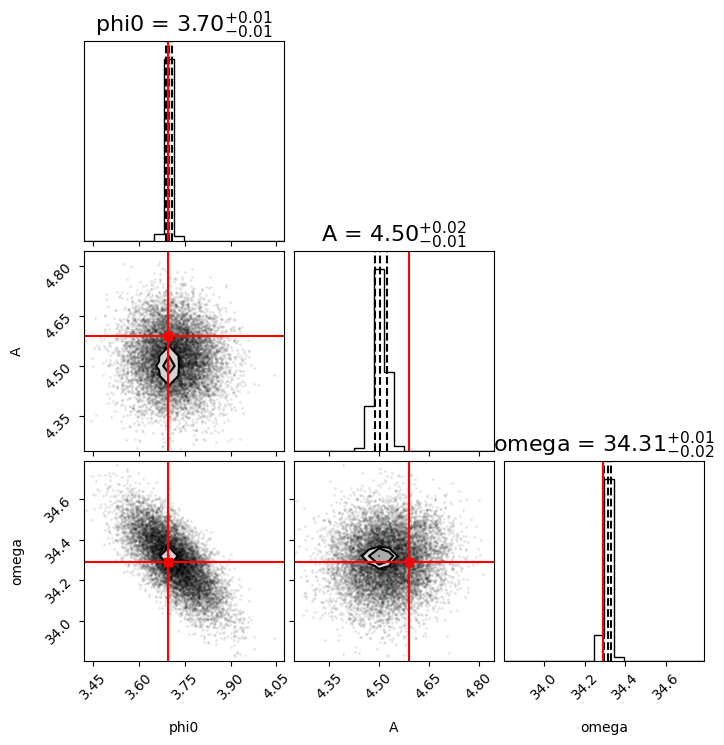

In [15]:
# change random seed to 1 and apply tiny noise only

for i in range(3):

    plt.figure(figsize=(5,3))
    np.random.seed(i*10)

    # draw random parameter from prior
    y_true = [var.rvs(1)[0] for var in priors]

    x_err = 0.1 * (i + 1)
    x_obs = sine(y_true) + np.random.normal(size=50) * x_err
    plt.errorbar(t, x_obs, yerr=x_err, fmt='.')
    plt.show()
    
    y_pred, weights = engine.predict(x_obs, x_err=np.array([0.1]*50), y_true=y_true, n_samples=10000, corner_reweight=True)
    plt.show()

Note that the above is only a demonstration. Let's try a much larger training set

In [22]:
# hyperparameters for the normalizing flow
flow = {
    'n_dims': 3,              # dimension of parameter space
    'flow_hidden': 128,
    'num_blocks': 10
}

# the NBI package provides the "ResNet-GRU" network as the default
# featurizer network for sequential data
featurizer = {
    'type': 'resnet-gru',
    'norm': 'weight_norm',
    'dim_in': 1,
    'dim_out': 128,
    'dim_conv_max': 128,
    'depth': 3
}

# initialize NBI engine
engine = nbi.NBI(
    flow=flow,
    featurizer=featurizer,
    simulator=sine,
    priors=priors,
    labels=labels,
    device='cpu',
    n_jobs=10
)

In [23]:
engine.fit(
    n_sims=5120*40,
    n_rounds=1,
    n_epochs=125,
    batch_size=256,
    lr=0.001,
    early_stop_patience=10,        # Within a round, wait this many epochs before early stopping
    noise=noise
)

Auto learning rate to min_lr = 1e-07
Generating simulations


20480it [00:11, 1818.73it/s]



---------------------- Round: 0 ----------------------


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x13f925d00>
Traceback (most recent call last):
  File "/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1497, in __del__
    self._shutdown_workers()
  File "/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1480, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/site-packages/multiprocess/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Epoch 8: Train, Loglike in nats: 5.183285:  73%|██████████████████████████████████████████▌               | 135424/184320 [00:38<00:17, 2802.59it/s]^^^^^
AssertionError: can only test a child process
Epoch 8: Train, Loglike in nats: 5.169884:  87%|██████████████████████████████████████████

  File "/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1497, in __del__
    self._shutdown_workers()
  File "/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1480, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/site-packages/multiprocess/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Epoch 8: Train, Loglike in nats: 5.172562:  90%|████████████████████████████████████████████████████▍     | 166656/184320 [00:47<00:05, 3162.96it/s]^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x13f925d00>
Traceback (most recent call last):
  File "/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1497, in _

- Val, Loglike in nats: 6.062906: 100%|█████████████████████████████████████████████████████████████████████| 20480/20480 [00:02<00:00, 9354.79it/s]


- Val, Loglike in nats: 6.371789:   1%|▉                                                                      | 256/20480 [00:00<00:06, 3302.58it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x13f925d00>
Traceback (most recent call last):
  File "/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1497, in __del__
    self._shutdown_workers()
  File "/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1480, in _shutdown_workers
    if w.is_alive():
Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x13f925d00>Exception ignored in:  
<function _MultiProcessingDataLoaderIter.__del__ at 0x13f925d00> Traceback (most recent call last):

   File "/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1497, in __del__
Traceback (most recent call last):
   File "/Users/Keming/anacon


       assert self._parent_pid == os.getpid(), 'can only test a child process' ^
 ^  ^  ^  ^  ^  ^  ^  ^  ^^ ^^ ^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^AssertionError^^^: ^can only test a child process^^^^
^^^^^^^^^
- Val, Loglike in nats: 6.348567:   4%|██▋                                                                    | 768/20480 [00:00<00:08, 2410.32it/s]AssertionError^: ^can only test a child process^

AssertionError: can only test a child process
- Val, Loglike in nats: 6.408452:  68%|█████████████████████████████████████████████▉                      | 13824/20480 [00:01<00:00, 10077.19it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x13f925d00>
Traceback (most recent call last):
  File "/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1497, in __del__
    self._shutdown_workers()
  File "/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/site-packages/torch/utils

- Val, Loglike in nats: 6.336198:  69%|███████████████████████████████████████████████▍                     | 14080/20480 [00:01<00:00, 9559.01it/s]^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
- Val, Loglike in nats: 6.220394:   5%|███▌                                                                  | 1024/20480 [00:00<00:03, 4896.28it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x13f925d00>
Traceback (most recent call last):
  File "/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1497, in __del__
    self._shutdown_workers()
  File "/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1480, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/site-packages/multiprocess/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(),

- Val, Loglike in nats: 6.699916: 100%|█████████████████████████████████████████████████████████████████████| 20480/20480 [00:02<00:00, 9271.44it/s]


- Val, Loglike in nats: 6.782590: 100%|█████████████████████████████████████████████████████████████████████| 20480/20480 [00:02<00:00, 9678.66it/s]


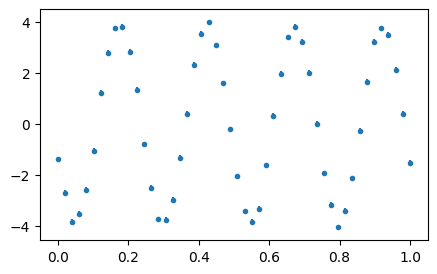

Generating simulations


1000it [00:00, 2140.89it/s]


Effective Sample Size = 6453.8
Sampling efficiency = 64.5%


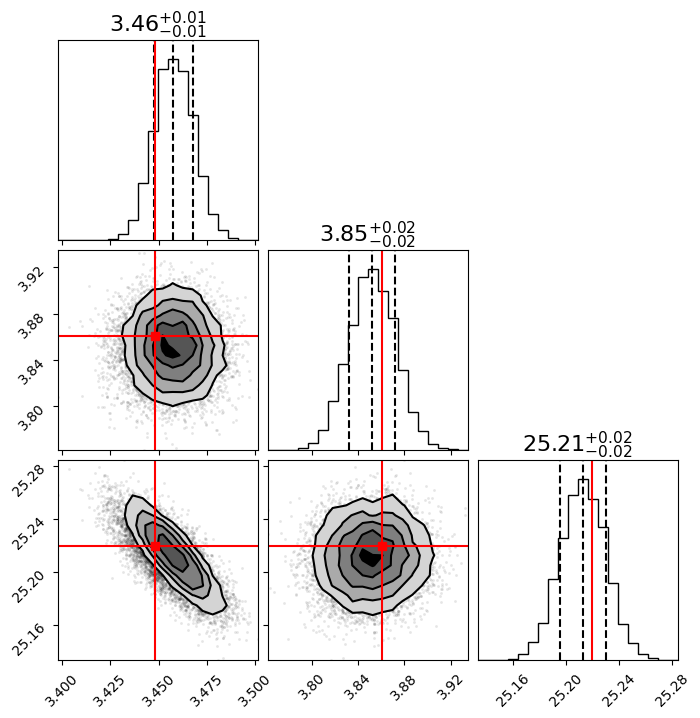

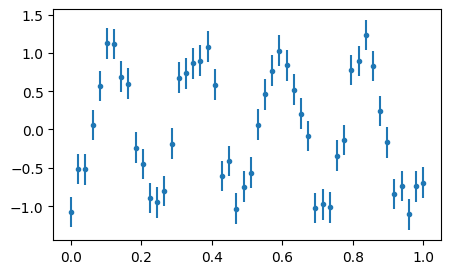

Samples outside prior N = 1000
Generating simulations


900it [00:00, 2432.25it/s]


Effective Sample Size = 1894.1
Sampling efficiency = 18.9%


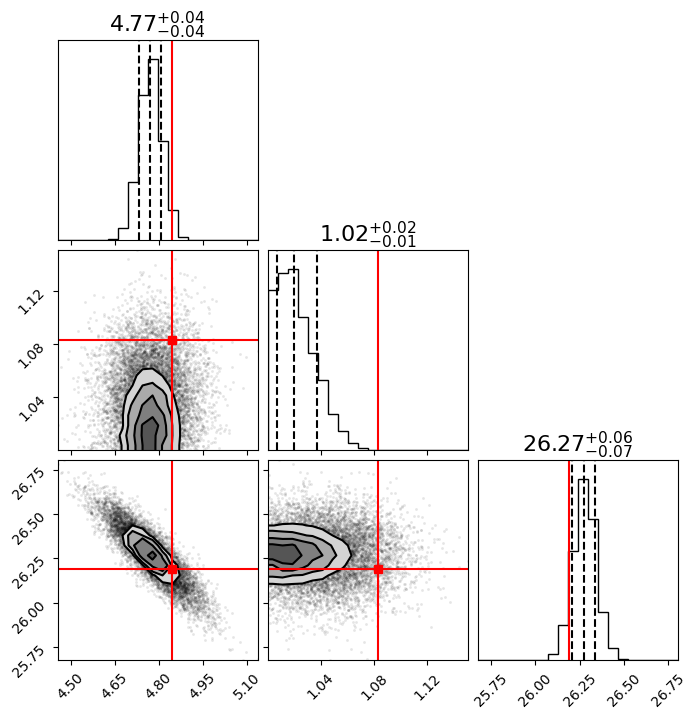

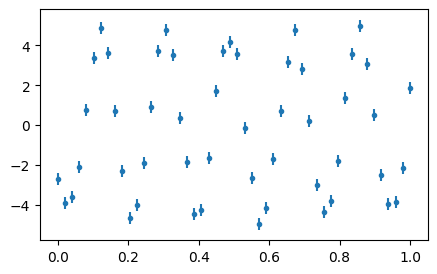

Generating simulations


1000it [00:00, 2089.58it/s]


Effective Sample Size = 856.4
Sampling efficiency = 8.6%


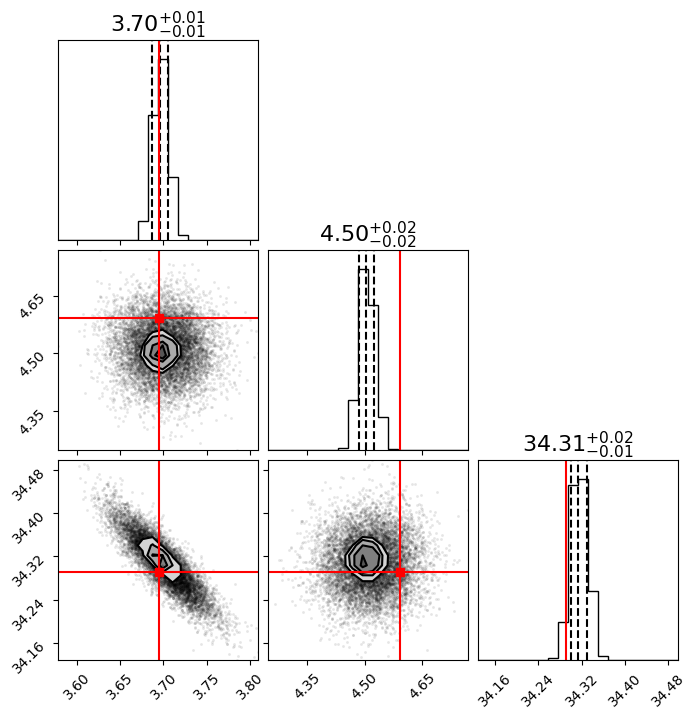

In [24]:
for i in range(3):

    plt.figure(figsize=(5,3))
    np.random.seed(i*10)

    # draw random parameter from prior
    y_true = [var.rvs(1)[0] for var in priors]

    x_err = 0.1 * (i + 1)
    x_obs = sine(y_true) + np.random.normal(size=50) * x_err
    plt.errorbar(t, x_obs, yerr=x_err, fmt='.')
    plt.show()
    
    y_pred, weights = engine.predict(x_obs, x_err=np.array([0.1]*50), y_true=y_true, n_samples=10000, corner_reweight=True)
    plt.show()